In [1]:
import sympy as sp
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# The following is based on https://en.wikipedia.org/wiki/Neo-Hookean_solid
# -> Uniaxial Extension / Compressible neo-Hookean material

In [3]:
# Neo-Hookean
C1, D1 = sp.symbols(r'C_{1} D_{1}', positive=True)
J, I1n, I1 = sp.symbols(r'J \bar{I_1} I_1')
Psi_NH = C1 * (I1n - 3) + D1 * (J-1)**2

Psis = [Psi_NH]
Psi  = Psis[0]
display(Psi)

C_{1}*(\bar{I_1} - 3) + D_{1}*(J - 1)**2

In [4]:
mu, lmbda = sp.symbols(r'\mu \lambda', positive=True)
C1Function  = mu / 2
D1Function  = lmbda / 2

lambda1, lambda2, lambda3 = sp.symbols(r'\lambda_1 \lambda_2 \lambda_3', positive=True)
JFunction  = lambda1 * lambda2 * lambda3
I1Function = lambda1**2+lambda2**2+lambda3**2
I2Function = lambda1**2*lambda2**2 + lambda2**2*lambda3**2 + lambda3**2*lambda1**2
I1nFunction= J**(-sp.Rational(2,3)) * I1Function
#Psi = Psi.subs({C1:C1Function,D1:D1Function, J:JFunction, I1:I1Function})
Psi_subs = Psi.subs({I1n:I1nFunction})
display(Psi_subs)
Psi_subs = Psi_subs.subs({J:JFunction})
display(Psi_subs)

C_{1}*(-3 + (\lambda_1**2 + \lambda_2**2 + \lambda_3**2)/J**(2/3)) + D_{1}*(J - 1)**2

C_{1}*(-3 + (\lambda_1**2 + \lambda_2**2 + \lambda_3**2)/(\lambda_1**(2/3)*\lambda_2**(2/3)*\lambda_3**(2/3))) + D_{1}*(\lambda_1*\lambda_2*\lambda_3 - 1)**2

In [5]:
# Cauchy Stress
sigma11, sigma22, sigma33 = sp.symbols(r'\sigma_{11} \sigma_{22} \sigma_{33}')
sigma11 = lambda1*sp.Derivative(Psi_subs, lambda1)/(lambda1*lambda2*lambda3)
sigma11 = sigma11.doit()
sigma22 = lambda2*sp.Derivative(Psi_subs, lambda2)/(lambda1*lambda2*lambda3)
sigma22 = sigma22.doit()
sigma33 = lambda3*sp.Derivative(Psi_subs, lambda3)/(lambda1*lambda2*lambda3)
sigma33 = sigma33.doit()
display(sp.simplify(sigma11))

2*(C_{1}*(2*\lambda_1**2 - \lambda_2**2 - \lambda_3**2) + 3*D_{1}*\lambda_1**(5/3)*\lambda_2**(5/3)*\lambda_3**(5/3)*(\lambda_1*\lambda_2*\lambda_3 - 1))/(3*\lambda_1**(5/3)*\lambda_2**(5/3)*\lambda_3**(5/3))

In [6]:
# uniaxial stretch ratio
stretch = sp.symbols(r'\hat{\lambda}', positive=True)
lambda1Function = stretch
lambda2Function = lambda2
lambda3Function = lambda2

# get stretch ratio on other two directions (lambda2)
JFunction_uniaxial = JFunction.subs({lambda1:lambda1Function, lambda2:lambda2Function, lambda3:lambda3Function})
lambda2Function_uniaxial = sp.solve(JFunction_uniaxial-J, lambda2)[1]
display(lambda2Function_uniaxial)


sqrt(J)/sqrt(\hat{\lambda})

In [7]:
# Compute Cauchy stress for uniaxial loading case
sigma11_uniaxial = sigma11.subs({lambda1:lambda1Function, lambda2:lambda2Function_uniaxial, lambda3:lambda2Function_uniaxial})
sigma22_uniaxial = sigma22.subs({lambda1:lambda1Function, lambda2:lambda2Function_uniaxial, lambda3:lambda2Function_uniaxial})
sigma33_uniaxial = sigma33.subs({lambda1:lambda1Function, lambda2:lambda2Function_uniaxial, lambda3:lambda2Function_uniaxial})
sp.simplify(sigma11_uniaxial)


2*(2*C_{1}*(-J + \hat{\lambda}**3) + 3*D_{1}*J**(5/3)*\hat{\lambda}*(J - 1))/(3*J**(5/3)*\hat{\lambda})

In [8]:
# Computation of sigma11 now requires value of J
# to eliminate J, we exploit that sigma22=sigma33=0
# therefore: sigma11 - sigma33 = sigma11
sigma_11_33_uniaxial = sp.simplify(sigma11_uniaxial - sigma33_uniaxial)
display(sigma_11_33_uniaxial)
# equating both expressions for sigma11 provides an expression for J
eqn_J = sp.simplify(sigma11_uniaxial - sigma_11_33_uniaxial)
sp.simplify(eqn_J)

-2*C_{1}*(J - \hat{\lambda}**3)/(J**(5/3)*\hat{\lambda})

2*(C_{1}*J - C_{1}*\hat{\lambda}**3 + 3*D_{1}*J**(5/3)*\hat{\lambda}*(J - 1))/(3*J**(5/3)*\hat{\lambda})

In [9]:
# this expression has no analytic solution for J
J_uniaxial = sp.solve(eqn_J, J)
J_uniaxial

[]

In [10]:
eqn_J_prime = sp.diff(eqn_J, J)
eqn_J_prime

-4*C_{1}/(9*J**(5/3)*\hat{\lambda}) + 10*C_{1}*\hat{\lambda}**2/(9*J**(8/3)) + 2*D_{1}

In [11]:
# therefore we try computing J numerically, given the other parameters: uniaxial stretch ratio, C1, D1
from scipy import optimize 

eqn_J_prime = sp.diff(eqn_J, J)
J_est_function = sp.lambdify((J, stretch, C1, D1), eqn_J, 'numpy')
J_est_prime_function = sp.lambdify((J, stretch, C1, D1), eqn_J_prime, 'numpy')

def compute_J(current_stretch, fixed_C1, fixed_D1):
    #J_est = optimize.root_scalar(J_est_function, x0=1, args=(current_stretch, fixed_C1, fixed_D1), method='brentq', bracket=[0.1,10])
    J_est = optimize.root_scalar(J_est_function, x0=1, args=(current_stretch, fixed_C1, fixed_D1), method='newton', fprime=J_est_prime_function)
    return J_est

# test
#root = compute_J(current_stretch=0.95, fixed_C1=0.1, fixed_D1=0.01)

In [12]:
# compute sigma11 using estimated J for given stretch, C1, D1

sigma11_uniaxial_function = sp.lambdify((J, stretch, C1, D1), sigma11_uniaxial, 'numpy')
sigma22_uniaxial_function = sp.lambdify((J, stretch, C1, D1), sigma22_uniaxial, 'numpy')

def compute_sigmas(stretch_array, C1, D1):
    sigma11 = np.zeros(stretch_array.shape)
    sigma22 = np.zeros(stretch_array.shape)
    for i in range(stretch_array.shape[0]):
        current_stretch = stretch_array[i]
        try:
            root = compute_J(current_stretch, C1, D1)
            J_est = root.root
            sigma11[i] = sigma11_uniaxial_function(J_est, current_stretch, C1, D1)
            sigma22[i] = sigma22_uniaxial_function(J_est, current_stretch, C1, D1)
        except Exception as e:
            print(e)
            sigma11[i] = np.nan
            sigma22[i] = np.nan
    return sigma11, sigma22

In [40]:
C_1 = 1e3
D_1 = 1e4

stretch_min = 0.1
stretch_max = 4
stretch_delta = 0.01
stretch_array = np.arange(stretch_min,stretch_max,stretch_delta)

sigma11, sigma22 = compute_sigmas(stretch_array, C_1, D_1)

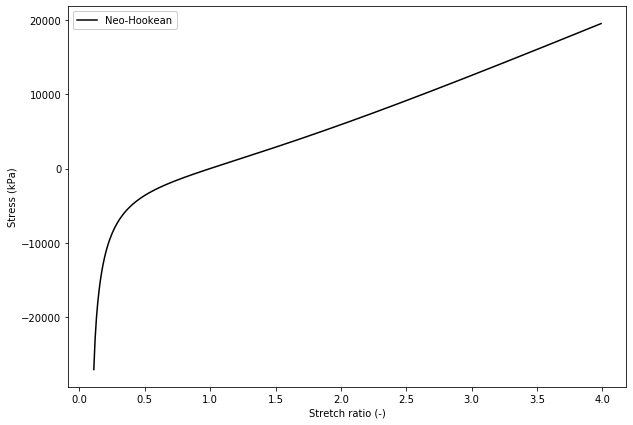

In [41]:

plt.rc('figure', figsize=[10,7])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.cla()
ax.plot(stretch_array, sigma11,  color = 'k', linestyle = '-', label='Neo-Hookean')
ax.set_xlabel('Stretch ratio (-)')
ax.set_ylabel('Stress (kPa)')
# plt.xlim([0.8, 1.2])
# plt.ylim([-0.5, 0.5])
plt.legend(loc='upper left', frameon=True, framealpha=1)
plt.show()

In [54]:
DataFrame = pd.DataFrame({'Stretch Ratio (-)':stretch_array, 'Analytical Stress (kPa)':sigma11})
DataFrame.to_csv('D1_1E4_Jcomputation.csv', index=False)

In [53]:
DataFrame

,Stretch Ratio (-),Analytical Stress (kPa)
0,0.10,NaN
1,0.11,-27042.706235
2,0.12,-22898.461617
3,0.13,-20139.850499
4,0.14,-18069.190439
...,...,...
385,3.95,19217.684207
386,3.96,19288.985391
387,3.97,19360.298495
388,3.98,19431.623324
